# Requirements

In [ ]:
!python --version

Python 3.6.9


In [ ]:
install_packages = True
if install_packages:
  !pip install html2text
  !pip install scikit-learn-extra
  !pip install kneed

     |████████████████████████████████| 624kB 6.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=339567 sha256=82fb59197faecd8a89225aedc5047a830c392de17928f749255fbc51cce59f37
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


In [ ]:
#imports
import pandas as pd
import numpy as np
import math
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import kneed
import collections
import umap
from sklearn_extra.cluster import KMedoids
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
from difflib import get_close_matches

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
working_dir = '/content/drive/My Drive/Colab Notebooks/CSMA/project/'
data_path = working_dir + 'data/videos/7I5RLbbXgPc/input/videoinfo_7I5RLbbXgPc_2021_02_06-10_18_06_comments.tab'
output_path = working_dir + 'data/videos/7I5RLbbXgPc/output/'

In [ ]:
new_embeddings = False # set to True if embeddings need to be computed

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

In [ ]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

In [ ]:
#data.shape

# Preprocessing

- Drop empty rows
- Drop unused columns

In [ ]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

In [ ]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

# Save or load preprocessed Data

In [ ]:
if new_embeddings:
    data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
    data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2021-01-18 20:32:32,Vighneshwar Anantharamakrishnan,"Really climate change comes in four parts tell that to the climate scientists. <br />1.)- does climate change? Yes it does no one is denying it<br />2.)- Do humans probably affect the climate? really you think that a population of over 8 billion people doesn&#39;t have an impact on the environment and the climate.<br />3.)-Is it a crisis, might be possible? Yeah explain that to the people who are affected by Hurricanes, Tornados, Wildfires, and Earthquakes about it not being a crisis. <br />4.)-Is anything we do going to make a significant difference? Yes, I agree that anything we do will not make the issue better if we keep burning fossil fuels and elevating the weather patterns, also without trying to take back the historical carbon emissions the United States and other countries like the E.U. we won&#39;t solve anything just increasing the number of problems.<br />Hurting poor people really? The people that are hurt by this and almost all citizens are corporations who do bad business practices and cause issues on the environment, we have people drinking PHAS infested chemicals, lead and other toxic waste so don&#39;t start saying this is one person fault its all of our fault for not taking action and doing anything.",0,"Really climate change comes in four parts tell that to the climate scientists. \n1.)- does climate change? Yes it does no one is denying it \n2.)- Do humans probably affect the climate? really you think that a population\nof over 8 billion people doesn't have an impact on the environment and the\nclimate. \n3.)-Is it a crisis, might be possible? Yeah explain that to the people who are\naffected by Hurricanes, Tornados, Wildfires, and Earthquakes about it not\nbeing a crisis. \n4.)-Is anything we do going to make a significant difference? Yes, I agree\nthat anything we do will not make the issue better if we keep burning fossil\nfuels and elevating the weather patterns, also without trying to take back the\nhistorical carbon emissions the United States and other countries like the\nE.U. we won't solve anything just increasing the number of problems. \nHurting poor people really? The people that are hurt by this and almost all\ncitizens are corporations who do bad business practices and cause issues on\nthe environment, we have people drinking PHAS infested chemicals, lead and\nother toxic waste so don't start saying this is one person fault its all of\nour fault for not taking action and doing anything.\n\n"
1,2021-01-18 20:34:15,Vighneshwar Anantharamakrishnan,"Yeah, many of the things in the Paris Agreement are not good either, which I will agree with but, we are not dealing with historical emissions. THis needs to be solved",1,"Yeah, many of the things in the Paris Agreement are not good either, which I\nwill agree with but, we are not dealing with historical emissions. THis needs\nto be solved\n\n"
2,2021-01-11 21:18:30,Ben Bethel,"Imagine this... Stimulus for solar, wind and battery programs results in $0 monthly utility bills (and auto fuel bills) for residential and commercial customers. This increases profits, makes us more competitive against other nations, and increases disposable income to spend on businesses, increases savings and investments in markets, and decreases amount governments have to provide in welfare when people need public assistance, unemployment, stimulus, which helps decrease taxes. Please debate.",0,"Imagine this... Stimulus for solar, wind and battery programs results in $0\nmonthly utility bills (and auto fuel bills) for residential and commercial\ncustomers. This increases profits, makes us more competitive against other\nnations, and increases disposable income to spend on businesses, increases\nsavings and investments in markets, and decreases amount governments have to\nprovide in welfare when people need public assistance, unemployment, stimulus,\nwhich helps decrease taxes.

# Produce Text Embeddings with Universal Sentence Encoder

In [ ]:
# Load model

hub_url = url_dict[model_type]
if new_embeddings:
    print("Loading model. This will take some time...")
    embed = hub.load(hub_url)

In [ ]:
# Embed Documents

if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

(699, 512)

# Calculate Similarity Matrix

In [ ]:
# Calculate Similarity Matric with angular distance (following Cer et al. (2018))

from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.0000002   0.3770362   0.19958037 ... -0.03412433  0.01915985
   0.4332369 ]
 [ 0.3770362   1.0000002   0.12642857 ... -0.05600467  0.1899356
   0.3792789 ]
 [ 0.19958037  0.12642857  0.99999976 ... -0.02860104  0.05487927
   0.18496168]
 ...
 [-0.03412433 -0.05600467 -0.02860104 ...  1.0000002  -0.0167702
   0.01263474]
 [ 0.01915985  0.1899356   0.05487927 ... -0.0167702   0.9999999
   0.23996732]
 [ 0.4332369   0.3792789   0.18496168 ...  0.01263474  0.23996732
   0.99999964]]


In [ ]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=0.8)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 375

# plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Clustering 

## Load Data

In [ ]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [ ]:
data.head()

,publishedAt,authorName,text,isReply,cleaned,label_manual
0,2021-01-18 20:32:32,Vighneshwar Anantharamakrishnan,"Really climate change comes in four parts tell that to the climate scientists. <br />1.)- does climate change? Yes it does no one is denying it<br />2.)- Do humans probably affect the climate? really you think that a population of over 8 billion people doesn&#39;t have an impact on the environment and the climate.<br />3.)-Is it a crisis, might be possible? Yeah explain that to the people who are affected by Hurricanes, Tornados, Wildfires, and Earthquakes about it not being a crisis. <br />4.)-Is anything we do going to make a significant difference? Yes, I agree that anything we do will not make the issue better if we keep burning fossil fuels and elevating the weather patterns, also without trying to take back the historical carbon emissions the United States and other countries like the E.U. we won&#39;t solve anything just increasing the number of problems.<br />Hurting poor people really? The people that are hurt by this and almost all citizens are corporations who do bad business practices and cause issues on the environment, we have people drinking PHAS infested chemicals, lead and other toxic waste so don&#39;t start saying this is one person fault its all of our fault for not taking action and doing anything.",0,"Really climate change comes in four parts tell that to the climate scientists. \n1.)- does climate change? Yes it does no one is denying it \n2.)- Do humans probably affect the climate? really you think that a population\nof over 8 billion people doesn't have an impact on the environment and the\nclimate. \n3.)-Is it a crisis, might be possible? Yeah explain that to the people who are\naffected by Hurricanes, Tornados, Wildfires, and Earthquakes about it not\nbeing a crisis. \n4.)-Is anything we do going to make a significant difference? Yes, I agree\nthat anything we do will not make the issue better if we keep burning fossil\nfuels and elevating the weather patterns, also without trying to take back the\nhistorical carbon emissions the United States and other countries like the\nE.U. we won't solve anything just increasing the number of problems. \nHurting poor people really? The people that are hurt by this and almost all\ncitizens are corporations who do bad business practices and cause issues on\nthe environment, we have people drinking PHAS infested chemicals, lead and\nother toxic waste so don't start saying this is one person fault its all of\nour fault for not taking action and doing anything.\n\n",-1.0
1,2021-01-18 20:34:15,Vighneshwar Anantharamakrishnan,"Yeah, many of the things in the Paris Agreement are not good either, which I will agree with but, we are not dealing with historical emissions. THis needs to be solved",1,"Yeah, many of the things in the Paris Agreement are not good either, which I\nwill agree with but, we are not dealing with historical emissions. THis needs\nto be solved\n\n",-1.0
2,2021-01-11 21:18:30,Ben Bethel,"Imagine this... Stimulus for solar, wind and battery programs results in $0 monthly utility bills (and auto fuel bills) for residential and commercial customers. This increases profits, makes us more competitive against other nations, and increases disposable income to spend on businesses, increases savings and investments in markets, and decreases amount governments have to provide in welfare when people need public assistance, unemployment, stimulus, which helps decrease taxes. Please debate.",0,"Imagine this... Stimulus for solar, wind and battery programs results in $0\nmonthly utility bills (and auto fuel bills) for residential and commercial\ncustomers. This increases profits, makes us more competitive against other\nnations, and increases disposable income to spend on businesses, increases\nsavings and investments in markets, and decreases amount governments have to\nprovide in welfare when people need public assistance, unemployment, stimulus,\nwhic

In [ ]:
number_of_comments = data.shape[0]
print('Number of comments:', number_of_comments)

Number of comments: 699


In [ ]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

## Dimensionality reduction with UMAP
We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. The number of dimensions (num_dimensions) depends on the number of samples

In [ ]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

## Optimize the Number of Clusters

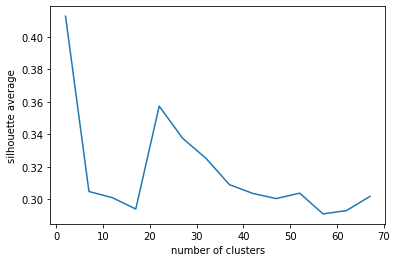

In [ ]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=math.ceil(number_of_comments/10)
step=5

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        # print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

In [ ]:
results = results.sort_values(by=['silhouette average'], ascending=False)
results.head(10)

,number of clusters,silhouette average
0,2,0.412713
4,22,0.357422
5,27,0.337640
6,32,0.325287
7,37,0.309124
1,7,0.304897
10,52,0.303891
8,42,0.303708
13,67,0.301890
2,12,0.301123


In [ ]:
x = results['number of clusters']
y = results['silhouette average']
kn = kneed.KneeLocator(x, y, curve='convex')
number_of_clusters = kn.knee
print('Optimal number of clusters:', number_of_clusters)

Optimal number of clusters: 57


## Clustering with KMedoids

In [ ]:
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
# print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

In [ ]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

## Dimensionality Reduction for Visualization

In [ ]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_clustering.fit_transform(embeddings)

## Visualize Clustering Results

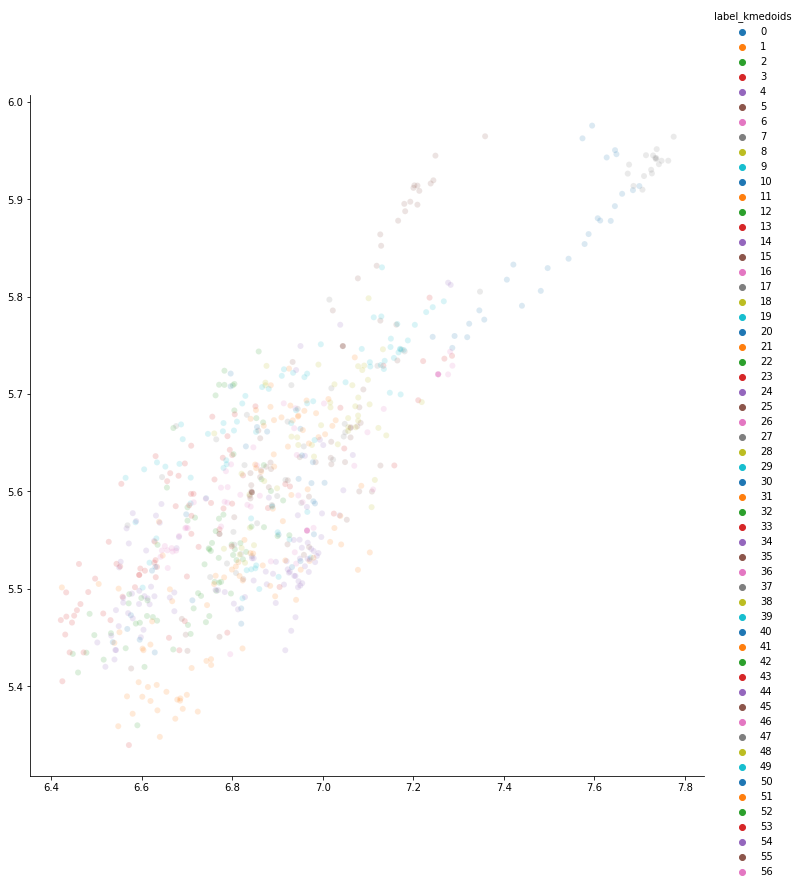

In [ ]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "tab10" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)

## Print Medoids and cluster statistics

In [ ]:
# print the medoids 

data.iloc[medoids_indices]

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids
562,2017-09-21 18:53:31,Doc Bauk,Ken Van de Burgt you are welcome to your hypothesis but the next step is to prove it. The link above shows you how you can do this in the video. You also need to add in some natural variation and those can be seen in the video in this link. Have fun doing some science. Aka proving your hypothesis. The work is waiting for your results. https://www.skepticalscience.com/co2-temperature-correlation.htm,1,you are welcome to your hypothesis but the next step is to\nprove it. The link above shows you how you can do this in the video. You also\nneed to add in some natural variation and those can be seen in the video in\nthis link. Have fun doing some science. Aka proving your hypothesis. The work\nis waiting for your results. \ncorrelation.htm\n\n,-1.0,0,5.960464e-08
221,2018-05-28 14:56:29,Francisco Dueñas,STOSSELL is REALLY stupid....,0,STOSSELL is REALLY stupid....\n\n,-1.0,1,0.000000e+00
8,2020-08-04 21:46:49,Eric Fournier,"Natural climate change is driven by just 2 things: The sun, and the Earth&#39;s axial tilt. Therefore, of course, climate change is real. Right now we&#39;re enjoying a warming period in Earth&#39;s history, as the Earth has been tilting more and more SE on its axis toward the sun on summer side of orbit---which means sunlight is more and more direct in the N hemisphere. As for MAN-MADE climate change, that too is real. But only in the form of stratospheric aerosols, and how they&#39;re being injected into the atmosphere to buy time against the warming.",0,"Natural climate change is driven by just 2 things: The sun, and the Earth's\naxial tilt. Therefore, of course, climate change is real. Right now we're\nenjoying a warming period in Earth's history, as the Earth has been tilting\nmore and more SE on its axis toward the sun on summer side of orbit---which\nmeans sunlight is more and more direct in the N hemisphere. As for MAN-MADE\nclimate change, that too is real. But only in the form of stratospheric\naerosols, and how they're being injected into the atmosphere to buy time\nagainst the warming.\n\n",-1.0,2,1.192093e-07
336,2018-04-22 19:06:19,David Hoffman,"Michael Rudge Don't pay any attention to this anti copy and paster, he left this exact comment on Jon LeVitre's comment 3 months ago except he referred to Carlson as ""he"" and has asked the exact same questions on at least 3 other comment threads. His shtick seems to be calling anyone who disagrees with him ""dumbass"" and saying they only believe scientists cause they went to school.",1,"Michael Rudge Don't pay any attention to this anti copy and paster, he left\nthis exact comment on 's comment 3 months ago except he referred to\nCarlson as ""he"" and has asked the exact same questions on at least 3 other\ncomment threads. His shtick seems to be calling anyone who disagrees with him\n""dumbass"" and saying they only believe scientists cause they went to school.\n\n",-1.0,3,1.788139e-07
343,2017-09-22 16:01:44,Ken Van de Burgt,"I disagree with anyone who has &#39;homogenized&#39;, &#39;fiddled&#39;, &#39;fudged&#39;, or &#39;fraudulently manipulated&#39; the data. It may have been done for the right reasons but the temperature data adjustments are best compared to stirring up already murky waters. <br /><br />When you leave out the &#39;homogenized&#39; surface temperature data all you have left is radiosonde and Satellite data that only goes back to 1958 and 1979 respectively. There hasn&#39;t been a long enough record to know if temperature has been rising or falling or if the changes are unusual. <br /><br />Certainly temperature isn&#39;t rising anywhere near as fast as the climate models have been predicting. The models are profoundly wrong and so the CO2 warming hypothesis is falsified. <br /><br />The information that the models are wrong has been widely circulated for at least 10 years. There is no excuse for continued igno

In [ ]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  4 mean distance from center:  0.0016182661056518555 Proportion of replies: 100.0
1 number of samples:  30 mean distance from center:  0.002174973451474216 Proportion of replies: 70.0
2 number of samples:  29 mean distance from center:  0.002592802047729492 Proportion of replies: 41.37931034482759
3 number of samples:  8 mean distance from center:  0.002434849739074707 Proportion of replies: 87.5
4 number of samples:  36 mean distance from center:  0.0017085008948924951 Proportion of replies: 66.66666666666667
5 number of samples:  3 mean distance from center:  0.0013013680472795386 Proportion of replies: 100.0
6 number of samples:  12 mean distance from center:  0.000331799196828797 Proportion of replies: 83.33333333333333
7 number of samples:  17 mean distance from center:  0.0003074898359045619 Proportion of replies: 17.647058823529413
8 number of samples:  20 mean distance from center:  0.002072453571599908 Proportion of replies: 80.0
9 number of samples:  5 me

## Count most frequent words

In [ ]:
stopwords_file = working_dir + 'data/stopwords/stopwords_list.txt' # NLTK's list of english stopwords (https://gist.github.com/sebleier/554280)

In [ ]:
with open(stopwords_file, 'r') as f:
  content = f.readlines()
stopwords = [x.strip() for x in content] 

In [ ]:
def count_most_frequent_words(cluster_df):  
  plain_text = ''

  for index, row in cluster_df.iterrows():
    plain_text = plain_text + row['cleaned'] + ' '

  wordcount = {}
  stopwords.append('$')

  for word in plain_text.lower().split():
      word = word.replace(".","")
      word = word.replace(",","")
      word = word.replace(":","")
      word = word.replace("\"","")
      word = word.replace("!","")
      word = word.replace("â€œ","")
      word = word.replace("â€˜","")
      word = word.replace("*","")
      if word not in stopwords:
          if word not in wordcount:
              wordcount[word] = 1
          else:
              wordcount[word] += 1

  return wordcount

In [ ]:
def plot_most_frequent_words(cluster_df, cluster_number):

  wordcount = count_most_frequent_words(cluster_df)

  # Print most common word
  n_print = 25
  # print("The {} most common words are as follows\n".format(n_print))
  word_counter = collections.Counter(wordcount)
  # for word, count in word_counter.most_common(n_print):
  #     print(word, ": ", count)
  # Create a data frame of the most common words 
  # Draw a bar chart
  lst = word_counter.most_common(n_print)
  df = pd.DataFrame(lst, columns = ['Word', 'Count'])

  title_string = 'Cluster' + str(cluster_number)
  df.plot.bar(x='Word',y='Count', title=title_string)

In [ ]:
 def get_potential_clusters(number_of_clusters, top_n, keywords):
   
   potential_cluster_ids = []
   
   for i in range(0, number_of_clusters):
     cluster_number =  i
     data['label_kmedoids'] = data['label_kmedoids'].astype('category')
     cluster = data[data['label_kmedoids']==cluster_number]
     cluster = cluster.sort_values(by='distance_kmedoids')
     wordcount = count_most_frequent_words(cluster)
     word_counter = collections.Counter(wordcount)
     lst = word_counter.most_common(top_n)
     len_lst = len(lst)
     
     for j in range(0, top_n):
       if j < len_lst:
         if len(get_close_matches(lst[j][0], keywords, cutoff=0.9)) != 0:
           potential_cluster_ids.append(i)

   return list(set(potential_cluster_ids)) # remove duplicates

In [ ]:
keywords_list = ['youtube', 'you tube', 'yt', 'google', 'wikipedia', 'wiki', 'censorship', 'censoring', 'censored',  'banner', 'bann', 'shadow banning', 'shadowbanning', 'removed', 'deleted', 'demonitized', 'demonitizing', 'restriction', 'disclaimer', 'warning label', 'free speeach']
potential_clusters = get_potential_clusters(number_of_clusters, 20, keywords_list)
print('Potential clusters of interest:',potential_clusters)

Potential clusters of interest: [24, 48, 36, 23]


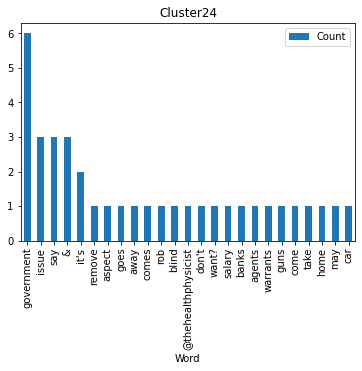

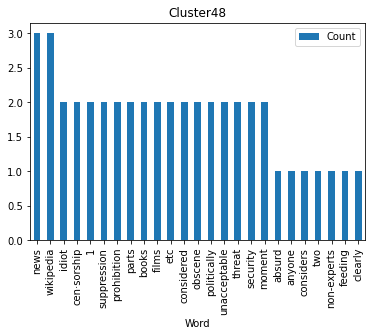

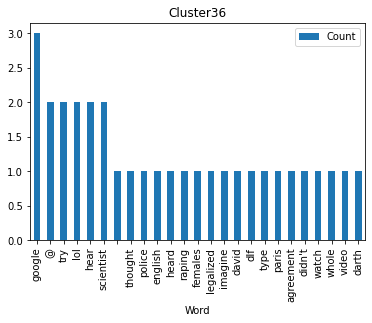

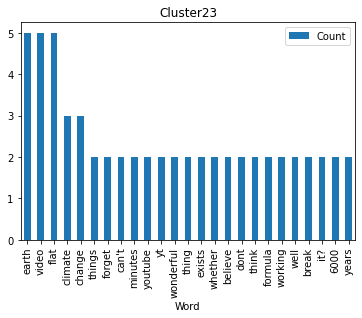

In [ ]:
for cluster_number in potential_clusters:
  cluster = data[data['label_kmedoids']==cluster_number]
  plot_most_frequent_words(cluster, cluster_number)

## Analyze specific Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [ ]:
def summarize_cluster(cluster_number):
  # Choose the number of samples to print
  number_of_samples_to_print = 10000
  data['label_kmedoids'] = data['label_kmedoids'].astype('category')
  cluster = data[data['label_kmedoids']==cluster_number]
  if cluster["text"].count()<=number_of_samples_to_print:
      number_of_samples_to_print = cluster["text"].count()
  cluster = cluster.sort_values(by='distance_kmedoids')
  print("Number of samples in the cluster:", cluster["text"].count())
  print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
  print('------------------------------------------------------------------------------------------------\n')
  for index, row in cluster.iterrows():
    print('Comment index:', index, '\n', row['cleaned'])

In [ ]:
# Choose a cluster to print
cluster_number =  48
summarize_cluster(cluster_number)

Number of samples in the cluster: 6
Average Distance from cluster center: 1.4036893844604492e-05
------------------------------------------------------------------------------------------------

Comment index: 150 
 WikiPedia link disclaimer is censorship and propaganda. Google's motto,
"First, do some evil".


Comment index: 177 
 Stop Censoring Youtube/Google. I don't need B.S. Wikipedia Warnings !!


Comment index: 153 
 cen·sorship -noun 1. the suppression or prohibition of any parts of books,
films, news, etc. that are considered obscene, politically unacceptable, or a
threat to security.


Comment index: 176 
 cen·sorship /ˈsensərSHip/ Learn to pronounce noun 1. the suppression or
prohibition of any parts of books, films, news, etc. that are considered
obscene, politically unacceptable, or a threat to security.


Comment index: 151 
 @ And then get their idiot edits promptly removed.


Comment index: 152 
 Wikipedia: The bastion of truth and accuracy....that any idiot can edit.
H

In [ ]:
# Choose a cluster to print
cluster_number =  28
summarize_cluster(cluster_number)

Number of samples in the cluster: 13
Average Distance from cluster center: 1.5020370483398438e-05
------------------------------------------------------------------------------------------------

Comment index: 422 
 hear hear!


Comment index: 124 
 @ Try English.


Comment index: 33 
 Google , thought police


Comment index: 628 
 try reading scientist
k


Comment index: 625 
 Here you go: 


Comment index: 41 
 [citation needed]


Comment index: 305 
 type into google "paris agreement"


Comment index: 669 
 Source citations?


Comment index: 16 
 ok boomer


Comment index: 224 
 What's your point?


Comment index: 428 
 YOU RACIST!!!!!!!!!


Comment index: 208 
 @ imagine being David DlF LOL


Comment index: 201 
 I heard that raping females was being legalized!.




In [ ]:
# Choose a cluster to print
cluster_number =  42
summarize_cluster(cluster_number)

Number of samples in the cluster: 9
Average Distance from cluster center: 2.8464528440963477e-05
------------------------------------------------------------------------------------------------

Comment index: 175 
 Notice how YT is posting a disclaimer that global warming is real? Now YT is
censoring content


Comment index: 468 
 That is a comment only to be written by someone who doesn't have the attention
span to even watch a half of a 5 minute video. They don't deny climate change
and they say so multiple times within the first 3 minutes. You brainwashed
nutjob just can't stop putting your imagination and feeling over actually
listening.


Comment index: 401 
 our children got indoctrinated in our public schools ... they all saw Al
Gore's video's probably more than once..


Comment index: 470 
 where in the video did they denier it


Comment index: 170 
 Thank you YouTube for providing a warning label and link to Wikipedia on this
video! Your viewers are obviously too stupid to vi

## Analyze specific Comments

In [ ]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]

In [ ]:
comment_list = data["cleaned"].tolist()

In [ ]:
comment_index = 150
comment = data["cleaned"][comment_index]
print('Current analyzed comment:\n')
print(comment)
print('----------------------------------------------------------------------------------------------------------------\n')

for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 10)):
  print("Top similar comment {}: {}".format(i+1, value))

Current analyzed comment:

WikiPedia link disclaimer is censorship and propaganda. Google's motto,
"First, do some evil".


----------------------------------------------------------------------------------------------------------------

Top similar comment 1: WikiPedia link disclaimer is censorship and propaganda. Google's motto,
"First, do some evil".


Top similar comment 2: Stop Censoring Youtube/Google. I don't need B.S. Wikipedia Warnings !!


Top similar comment 3: WikiPedia link disclaimer is censorship and propaganda. Man made global
warming is a theory. Unproven. Consensus by Liberal scientists is not science.
Same was said about the earth being flat....What they knew at the time was
their reality not the truth.


Top similar comment 4: Wikipedia: The bastion of truth and accuracy....that any idiot can edit.
HA!!!!


Top similar comment 5: Thank you YouTube for providing a warning label and link to Wikipedia on this
video! Your viewers are obviously too stupid to view a video